In [ ]:
from quantrocket.license import set_license
set_license("876a241b-dfa4-11ee-bbcf-e352491c08d3")

{'licensekey': '876a........08d3', 'software_license': {}}

In [ ]:

from quantrocket.history import create_usstock_db
create_usstock_db("usstock-free-1d", bar_size="1 day", free=True)


In [ ]:
from quantrocket.history import collect_history
collect_history("usstock-free-1d")

{'status': 'the historical data will be collected asynchronously'}

In [ ]:
from quantrocket.master import get_securities
# by specifying sec_types='STK', we exclude ETFs, which are present in the sample data
securities = get_securities(vendors="usstock", sec_types="STK")
securities.head()

,Symbol,Exchange,Country,Currency,SecType,Etf,Timezone,Name,PriceMagnifier,Multiplier,Delisted,DateDelisted,LastTradeDate,RolloverDate
Sid,,,,,,,,,,,,,,
FIBBG000B9XRY4,AAPL,XNAS,US,USD,STK,False,America/New_York,APPLE INC,1,1,False,NaT,NaT,NaT
FIBBG000BFWKC0,MON,XNYS,US,USD,STK,False,America/New_York,MONSANTO CO,1,1,True,2018-06-06,NaT,NaT
FIBBG000BKZB36,HD,XNYS,US,USD,STK,False,America/New_York,HOME DEPOT INC,1,1,False,NaT,NaT,NaT
FIBBG000BMHYD1,JNJ,XNYS,US,USD,STK,False,America/New_York,JOHNSON & JOHNSON,1,1,False,NaT,NaT,NaT
FIBBG000BPH459,MSFT,XNAS,US,USD,STK,False,America/New_York,MICROSOFT CORP,1,1,False,NaT,NaT,NaT


In [ ]:
from quantrocket.master import create_universe
#create_universe("usstock-free", sids=securities.index.tolist())

replace_or_append = "replace"  # or "append"

create_universe("usstock-free", sids=securities.index.tolist(), replace=True)

{'code': 'usstock-free', 'provided': 8, 'inserted': 8, 'total_after_insert': 8}

## Filtering the apple stocks only

In [ ]:
filtered_securities = securities[securities.Symbol=="AAPL"]
# also limit the number of columns for readability
filtered_securities = filtered_securities[["Symbol", "Exchange", "Name", "Delisted"]]
filtered_securities.head()

,Symbol,Exchange,Name,Delisted
Sid,,,,
FIBBG000B9XRY4,AAPL,XNAS,APPLE INC,False


In [ ]:
create_universe("usstock-free-active", sids=filtered_securities.index.tolist())

## Getting the stock prices for the year 2023

In [ ]:
from quantrocket import get_prices
prices = get_prices("usstock-free-1d", universes="usstock-free-active", start_date="2023-01-01",end_date="2023-12-31" ,fields=["Close"])
#displaying first 10 records
prices.head(10)

Sid               FIBBG000B9XRY4
Field Date                      
Close 2023-01-03        124.2163
      2023-01-04        125.4975
      2023-01-05        124.1666
      2023-01-06        128.7352
      2023-01-09        129.2616
      2023-01-10        129.8377
      2023-01-11        132.5788
      2023-01-12        132.4994
      2023-01-13        133.8402
      2023-01-17        135.0121

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("appleStock.csv",parse_dates=True)
df.set_index('Date', inplace=True)
df = df.drop(["Field"],axis="columns")

In [ ]:
df.rename(columns={'FIBBG000B9XRY4': 'Close Price'}, inplace=True)
df.head(3)

,Close Price
Date,
2023-01-03,124.2163
2023-01-04,125.4975
2023-01-05,124.1666


In [ ]:
df['Returns'] = df['Close Price'].pct_change()
df['Returns'] = df['Returns'].bfill()


def classify_state(returns):
    if returns >= 0.01:
        return 1
    elif returns > -0.01:
        return 0
    else:
        return -1

df['State'] = df['Returns'].apply(classify_state)
df.head(3)

,Close Price,Returns,State
Date,,,
2023-01-03,124.2163,0.010314,1
2023-01-04,125.4975,0.010314,1
2023-01-05,124.1666,-0.010605,-1


In [ ]:
row,col = df.shape
print("row: ",row)
print("col: ",col)
df["Portfolio value"] = 0

row:  250
col:  3


### To maximise the portfolio value, we place buy order on day (d+1) if :
###      It has flat state on that day (d) and bull state on the day (d+1)

In [ ]:
optimal_indices = {}
for i in range(0, row-1):
    if df.iloc[i, df.columns.get_loc("State")] == 0 and df.iloc[i+1, df.columns.get_loc("State")] == 1:
        df.iloc[i+1, df.columns.get_loc("Portfolio value")] = df.iloc[i, df.columns.get_loc("Portfolio value")] + 1
        optimal_indices[df.index[i+1]] = df["Portfolio value"][i+1]
    else:
        df.iloc[i+1, df.columns.get_loc("Portfolio value")] = df.iloc[i, df.columns.get_loc("Portfolio value")]


In [ ]:
pd.set_option('display.max_rows',251)

In [ ]:
df.head(20)

,Close Price,Returns,State,Portfolio value
Date,,,,
2023-01-03,124.2163,0.010314,1,0
2023-01-04,125.4975,0.010314,1,0
2023-01-05,124.1666,-0.010605,-1,0
2023-01-06,128.7352,0.036794,1,0
2023-01-09,129.2616,0.004089,0,0
2023-01-10,129.8377,0.004457,0,0
2023-01-11,132.5788,0.021112,1,1
2023-01-12,132.4994,-0.000599,0,1
2023-01-13,133.8402,0.010119,1,2


In [ ]:
df["Portfolio value"].max()

40

##  Calculating the transition distribution of going from a state to different possible states

In [ ]:
state_counts = df['State'].value_counts()
sc = dict(state_counts)

In [ ]:
def TPM(dictionary):
    tpm = pd.DataFrame(index=sc.keys(),columns=sc.keys())
    for i in sc.keys():
        for j in sc.keys():
            tpm.loc[i,j] = dictionary[(i,j)]
    return tpm

In [ ]:
from collections import defaultdict
dict_freq = defaultdict(int)
for state,tot in sc.items():
    for i in range(0,row-1):
        if df.State[i]==state:
            dict_freq[(state,df.State[i+1])] += 1/tot


In [ ]:
print("Transition probability matrix:\n\n",TPM(dict_freq))

Transition probability matrix:

            0         1        -1
 0  0.594937  0.253165   0.14557
 1  0.666667  0.210526  0.122807
-1  0.742857  0.114286  0.142857


## Time Series Plot

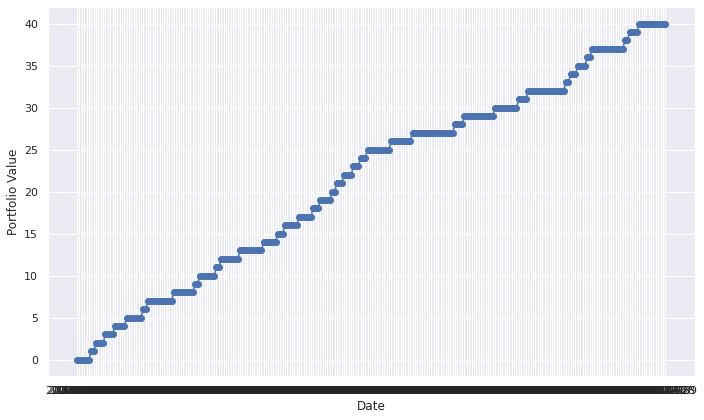

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Portfolio value'], marker='o', color='b', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)


plt.tight_layout()
plt.show()

## Optimal Buying indices

In [ ]:
print(optimal_indices)

{'2023-01-11': 1, '2023-01-13': 2, '2023-01-20': 3, '2023-01-26': 4, '2023-02-02': 5, '2023-02-13': 6, '2023-02-15': 7, '2023-03-03': 8, '2023-03-16': 9, '2023-03-20': 10, '2023-03-29': 11, '2023-03-31': 12, '2023-04-13': 13, '2023-04-27': 14, '2023-05-05': 15, '2023-05-10': 16, '2023-05-18': 17, '2023-05-26': 18, '2023-06-01': 19, '2023-06-08': 20, '2023-06-12': 21, '2023-06-15': 22, '2023-06-22': 23, '2023-06-27': 24, '2023-06-30': 25, '2023-07-17': 26, '2023-07-28': 27, '2023-08-23': 28, '2023-08-29': 29, '2023-09-18': 30, '2023-10-02': 31, '2023-10-06': 32, '2023-10-30': 33, '2023-11-01': 34, '2023-11-06': 35, '2023-11-10': 36, '2023-11-14': 37, '2023-12-05': 38, '2023-12-07': 39, '2023-12-13': 40}


In [ ]:
optimal_dates = pd.DataFrame()
optimal_dates["Dates"] = optimal_indices.keys()
optimal_dates["Portfolio value"] = optimal_indices.values()
optimal_dates.set_index("Dates")

,Portfolio value
Dates,
2023-01-11,1
2023-01-13,2
2023-01-20,3
2023-01-26,4
2023-02-02,5
2023-02-13,6
2023-02-15,7
2023-03-03,8
2023-03-16,9
